In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
plt.rcParams['figure.figsize'] = (16, 10)


In [ ]:

#tratando o mnist
mnist = fetch_openml('mnist_784', version=1, cache=True, parser='auto')
X_raw = mnist.data.values.astype('float32') / 255.0
y_raw = mnist.target.values.astype('int')

# One-hot encoding :D Em resumo, eu faço tudo ter entre 0 e 1 para sair somente 1 em cada uma das saídas,
# assim quando perguntado qual número é aquele, ele ativa por exemplo, o quarto número do vetor se ele
# quiser dizer que é um número 3
n_classes = 10
y_one_hot = np.eye(n_classes)[y_raw]

# Divisão Treino/Teste. Lembrar de machine learning
X_train, X_test, y_train, y_test = train_test_split(X_raw, y_one_hot, train_size=60000, test_size=10000, random_state=42)


In [ ]:

class RedeNeuralMNIST:
    def __init__(self, n_entradas, n_ocultos, n_saidas, lr=0.1):
        self.lr = lr
        np.random.seed(1)
        # Inicialização
        self.pesosEntradaOculta = np.random.randn(n_entradas, n_ocultos) * 0.1
        self.biasEntrada = np.zeros((1, n_ocultos))
        self.pesosOcultaSaida = np.random.randn(n_ocultos, n_saidas) * 0.1
        self.biasSaida = np.zeros((1, n_saidas))

    def sigmoide(self, x):
        x = np.clip(x, -500, 500)
        return 1 / (1 + np.exp(-x))

    def derivadaSigmoide(self, x):
        return x * (1 - x)

    def forward(self, X):
        self.s1 = np.dot(X, self.pesosEntradaOculta) + self.biasEntrada
        self.a1 = self.sigmoide(self.s1)
        self.s2 = np.dot(self.a1, self.pesosOcultaSaida) + self.biasSaida
        self.a2 = self.sigmoide(self.s2)
        return self.a2

    def train(self, X, y, epocas=1000, batch_size=128):
        acc_history = []
        loss_history = []
        n_samples = X.shape[0]

        print(f"Treinamento com {epocas}")

        for i in range(epocas):
            #tirar vies e embaralhar tudo
            indices = np.random.permutation(n_samples)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            # pegando só uma parte
            for j in range(0, n_samples, batch_size):
                X_batch = X_shuffled[j:j+batch_size]
                y_batch = y_shuffled[j:j+batch_size]

                # forward
                a2 = self.forward(X_batch)

                # backpropagation
                erro_saida = y_batch - a2
                delta_saida = erro_saida * self.derivadaSigmoide(a2)
                erro_oculta = delta_saida.dot(self.pesosOcultaSaida.T)
                delta_oculta = erro_oculta * self.derivadaSigmoide(self.a1)

                # atualização dos pesos
                self.pesosOcultaSaida += self.a1.T.dot(delta_saida) * self.lr
                self.pesosEntradaOculta += X_batch.T.dot(delta_oculta) * self.lr
                self.biasSaida += np.sum(delta_saida, axis=0, keepdims=True) * self.lr
                self.biasEntrada += np.sum(delta_oculta, axis=0, keepdims=True) * self.lr

            # armazenando pros gráficos
            if i % 10 == 0:
                predicao = self.forward(X)
                loss = np.mean(np.square(y - predicao))
                acc = np.mean(np.argmax(predicao, axis=1) == np.argmax(y, axis=1))

                acc_history.append(acc)
                loss_history.append(loss)

                # cada 25 epocas printa o erro.
            if i % 25 == 0:
                print(f"Época {i}/{epocas} - Erro: {loss:.4f} - Acurácia: {acc*100:.2f}%")

        return loss_history, acc_history

nn_mnist = RedeNeuralMNIST(n_entradas=784, n_ocultos=32, n_saidas=10, lr=0.01)
loss, acc = nn_mnist.train(X_train, y_train, epocas=200, batch_size=64)

predicoes_prob = nn_mnist.forward(X_test)
predicoes_finais = np.argmax(predicoes_prob, axis=1)
labels_reais = np.argmax(y_test, axis=1)

acc_test = np.mean(predicoes_finais == labels_reais)
print(f"Acurácia Final no Teste: {acc_test*100:.2f}%")

Treinamento com 200
Época 0/200 - Erro: 0.0257 - Acurácia: 87.86%
Época 25/200 - Erro: 0.0077 - Acurácia: 95.65%
Época 50/200 - Erro: 0.0055 - Acurácia: 97.06%
Época 75/200 - Erro: 0.0048 - Acurácia: 97.49%
Época 100/200 - Erro: 0.0041 - Acurácia: 97.84%
Época 125/200 - Erro: 0.0037 - Acurácia: 98.01%
Época 150/200 - Erro: 0.0034 - Acurácia: 98.21%
Época 175/200 - Erro: 0.0032 - Acurácia: 98.34%
Acurácia Final no Teste: 95.91%


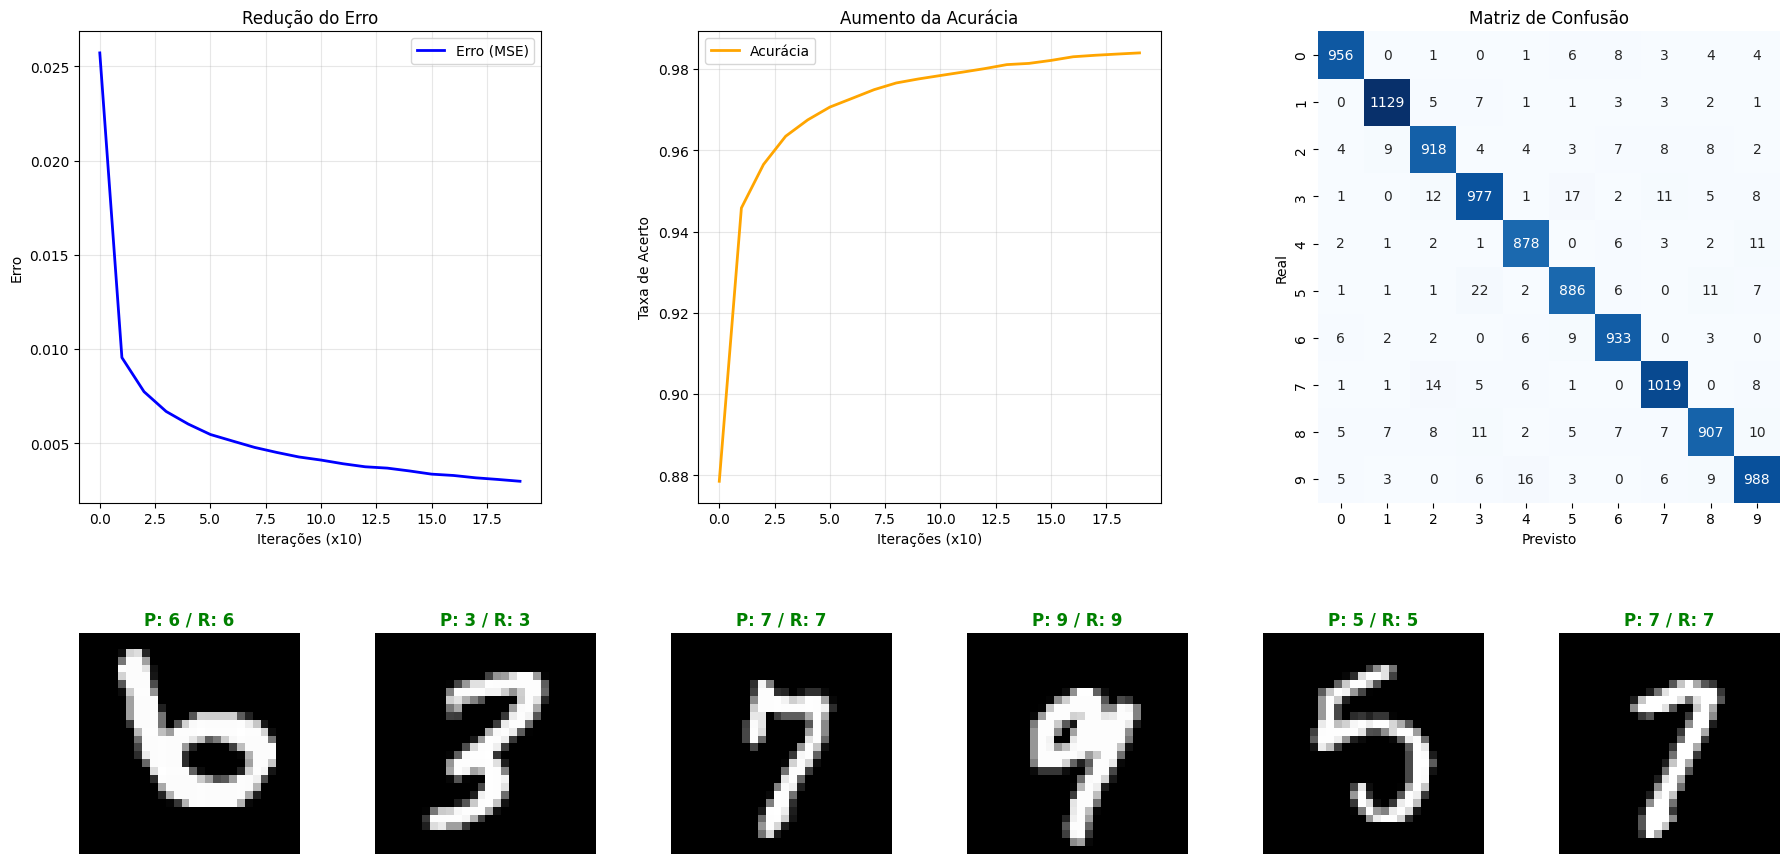

In [ ]:

plt.figure(figsize=(18, 10))

# Gráfico 1: Erro
plt.subplot(2, 3, 1)
plt.plot(loss, label='Erro (MSE)', color='blue', linewidth=2)
plt.title("Redução do Erro")
plt.xlabel("Iterações (x10)")
plt.ylabel("Erro")
plt.legend()
plt.grid(True, alpha=0.3)

# Gráfico 2: Acurácia
plt.subplot(2, 3, 2)
plt.plot(acc, label='Acurácia', color='orange', linewidth=2)
plt.title("Aumento da Acurácia")
plt.xlabel("Iterações (x10)")
plt.ylabel("Taxa de Acerto")
plt.legend()
plt.grid(True, alpha=0.3)

# Gráfico 3: Matriz de Confusão
plt.subplot(2, 3, 3)
cm = confusion_matrix(labels_reais, predicoes_finais)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Matriz de Confusão")
plt.ylabel("Real")
plt.xlabel("Previsto")

# Imagens de Teste/Não tem utilidade real
rng = np.random.default_rng()
indices_teste = rng.choice(len(X_test), 6, replace=False)

for i, idx in enumerate(indices_teste):
    plt.subplot(2, 6, 7 + i)

    img = X_test[idx].reshape(28, 28)
    pred = predicoes_finais[idx]
    real = labels_reais[idx]

    plt.imshow(img, cmap='gray')

    cor = 'green' if pred == real else 'red'
    plt.title(f"P: {pred} / R: {real}", color=cor, fontweight='bold')
    plt.axis('off')

plt.tight_layout()
plt.show()